# Analysis goals

1. Determine what data is relevant to show by a "results" object and its corresponding stats/plots.
2. Identify bugs or conceptual errors.
3. Examine runtime bottlenecks and determine how to speed up sim.

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pstats
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize_scalar
from datetime import datetime, timedelta
from collections import defaultdict
import timeit
from src.logging import get_logger
import logging
from src.configs import ADDRESS_TO_SYMBOL

pd.set_option("display.max_columns", None)

logger = get_logger(__name__)
logger.setLevel(logging.ERROR)  # turn warnings off

%load_ext autoreload
%autoreload 2

In [2]:
with open("../pickles/scenario.pkl", "rb") as f:
    scenario = pickle.load(f)
with open("../pickles/metrics_processor.pkl", "rb") as f:
    metrics_processor = pickle.load(f)

In [3]:
df = metrics_processor.df
df

,timestamp,arbitrageur_profit,arbitrageur_count,keeper_profit,keeper_count,liquidator_profit,liquidator_count,llamma_WETH_price,llamma_WETH_oracle_price,llamma_WETH_fees_x,llamma_WETH_fees_y,llamma_WETH_bal_x,llamma_WETH_bal_y,controller_WETH_system_health,controller_WETH_bad_debt,controller_WETH_num_loans,controller_WETH_debt,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,aggregator_price,stablecoin_total_supply
0,2023-12-07 23:46:51,39.572440,2,0.0,0,21.717548,1,2259261959063905891243,2362103738448813228032,0,0,0,13043008357994930247577,3.269989e+17,8460514463000398240415744,242,22079013407859927712561416,997368847461496910,997883823499257738,4602606359392449706784768,1000001238701040553,1301029235739346467626223,3302653086471258918264530,995589966058886161,994925052636487860,4983836723625910875895581,1000000701055327108,1130660984486496584399188,3855295130561327463490851,995381902689081258,995381902689081258,34645529894287462716996437,1000000000000000000,7698631371117,26962338324948319638621748,995256834644064172,995165555383440503,31464124727718726081483136,1000000094808104635,6907733824226,24570810668213876262549516,0,0,0,0,0,0,0,0,995262026817856098,316741807182550880301233753
1,2023-12-08 00:46:51,276.295296,5,0.0,0,21.717548,1,2232486451122583925198,2352755126620622300380,0,0,0,13043008357994930247577,3.215595e+17,8460514463000398240415744,242,22079294098971328524935733,998492694345287481,998483178014393458,4602606359392449706784768,1000004379566728300,1589749320997877810273519,3013362921052954775944007,995865443244160870,995850725637652472,4983836723625910875895581,1000001032862284848,1163638151447984906500436,3822178189801204965914490,994734908474940680,994983748098252778,34645529894287462716996437,1000000646246120752,7252439698980,27410764084382114869497271,995442147991286560,995437820268627889,31464124727718726081483136,1000000294818808073,7033195119933,24444769591428182949337111,0,0,0,0,0,0,0,0,995265216050458546,317190232941984675532109276
2,2023-12-08 01:46:51,676.294386,6,0.0,0,21.717548,1,2235329876053714069210,2353773520214595009808,0,0,0,13043008357994930247577,3.221283e+17,8460514463000398240415744,242,22079574790967495718219064,996971374713212106,996994962806548553,4602606359392449706784768,1000008311122188938,1228562864913550995834485,3375357314064551192114795,995865443244160870,995865215904351330,4983836723625910875895581,1000001032862284848,1163638151447984906500436,3822178189801204965914490,995265723919146917,995261315305063650,34645529894287462716996437,1000001167940341877,7612662498430,27048751589840714893149657,995442147991286560,995442082238885351,31464124727718726081483136,1000000294818808073,7033195119933,24444769591428182949337111,0,0,0,0,0,0,0,0,995392620343034867,317552227334996271948280064
3,2023-12-08 02:46:51,724.091248,7,0.0,0,21.717548,1,2242085276515472635747,2356167554936815064743,0,0,0,13043008357994930247577,3.234885e+17,8460514463000398240415744,242,22079930463357552585666634,996254007677323510,996265576110705064,4602606359392449706784768,1000009468766888015,1122268658771414074934088,34820164

<Axes: >

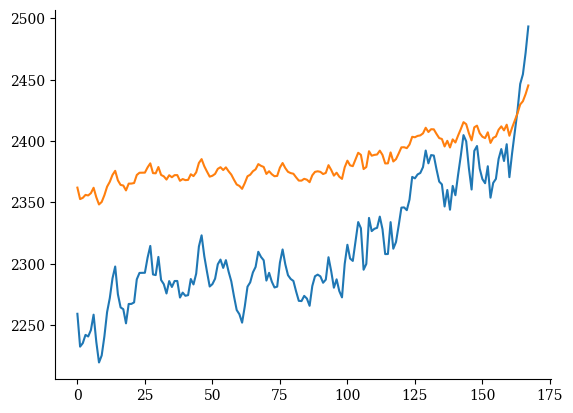

In [4]:
# LLAMMA price
(df["llamma_WETH_price"].astype(float) / 1e18).plot(label="Spot Price")
(df["llamma_WETH_oracle_price"].astype(float) / 1e18).plot(label="Oracle Price")
# TODO does it make sense that oracle price is a muted version of LLAMMA price?

## Runtime Profile

In [5]:
# TODO
# - Better bounds -> actually bracket not bounds -> this is the initial guess
# - Better solver (start by trying brent), then maybe custom barebones solver -> bounded seems better for now
# - Better tol -> should be 1 in the decimals of that token, not 1e-6 or whatever. Or maybe it should be $1 in the units of that token

# DONE
# tol
# solver

# Findings:
# 1. Bounded is always much faster than brents for whatever reason.
# 2. Providing a $1 tolerance creates a huge improvement.
# 3. Providing tighter bounds is hard. We don't actually know how much to tighten by.
# What we can do is: try a tighter bound, if the result is too close to the upper bound,
# default to max bound. We can then analyze the performance improvement of tighter bounds
# with random price changes. Notice that what matters here IS the magnitude of price changes.

In [57]:
def opt(cycle_, method, sample_, set_tol=False, disp=0, frac=1.0):
    # TODO find better way of setting frac
    trade = cycle_.trades[0]
    low = 0
    high = float(trade.pool.get_max_trade_size(trade.i, trade.j) * frac)

    if high == 0:
        return 0, 0, frac

    options = {"disp": disp}
    if set_tol:
        if method == "bounded":
            # Get 1 cent in USD (marked to market)
            decimals = trade.pool.coin_decimals[trade.i]
            address = trade.pool.coin_addresses[trade.i].lower()
            options["xatol"] = int(10**decimals / sample_.prices_usd[address])
        else:
            options["xtol"] = 1e-4  # TODO is 1bp a good tolerance?
    kwargs = {"args": (), "bracket": (low, high), "method": method, "options": options}
    if method == "bounded":
        kwargs["bounds"] = (low, high)
    res = minimize_scalar(lambda x: -cycle_.populate(x), **kwargs)

    pct_of_high = res.x / high * 100
    if disp == 3:
        print(f"Bounds: [{low}, {res.x}, {high}]")
        print(f"Pct of high: {pct_of_high:.2f}%")

    if method == "bounded":
        if frac != 1.0:
            if pct_of_high > 1:
                print(
                    "Upper bound was too low with frac=%f, defaulting to frac=1.", frac
                )
                return opt(cycle_, method, sample_, set_tol, disp, frac=1.0)
            elif not res.success:
                print("Optimization failed with frac=%f, defaulting to frac=1.", frac)
                return opt(cycle_, method, sample_, set_tol, disp, frac=1.0)

    if not res.success:
        print("Kwargs", kwargs)
        raise Exception("Optimization failed.")
    return res.x, res.fun, frac  # TODO remove frac from here

In [18]:
KNOWN_IDS_MAP = {
    "usd-coin": "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",
    "tether": "0xdac17f958d2ee523a2206206994597c13d831ec7",
    "paxos-standard": "0x8e870d67f660d95d5be530380d0ec0bd388289e1",
    "true-usd": "0x0000000000085d4780b73119b644ae5ecd22b376",
    "weth": "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",
    "wrapped-bitcoin": "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599",
    "wrapped-steth": "0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0",
    "staked-frax-ether": "0xac3e018457b222d93114458476f3e3416abbe38f",
    "tbtc": "0x18084fba666a33d37592fa2633fd49a74dd93a88",
}
KNOWN_IDS_MAP = {v: k for k, v in KNOWN_IDS_MAP.items()}
params = scenario.pricepaths.config["params"]

from src.prices.utils import gen_ou, gen_gbm


def random_price_update():
    sample = deepcopy(scenario.pricepaths[-1])
    prices_usd = sample.prices_usd
    for address_ in prices_usd:
        prices_usd[address_] = random_price_update_(address_, prices_usd[address_])
    sample.update(prices_usd)
    sample.timestamp += timedelta(hours=1)
    scenario.prepare_for_trades(sample)


def random_price_update_(address_, s0):
    dt = 1 / (365 * 24)  # FIXME assumed hourly
    coin_params = params[KNOWN_IDS_MAP[address_]]
    if coin_params["type"] == "OU":
        return gen_ou(
            coin_params["theta"], coin_params["mu"], coin_params["sigma"], dt, s0, 2
        )[-1]
    elif coin_params["type"] == "GBM":
        return gen_gbm(coin_params["mu"], coin_params["sigma"], dt, s0, 2)[-1]

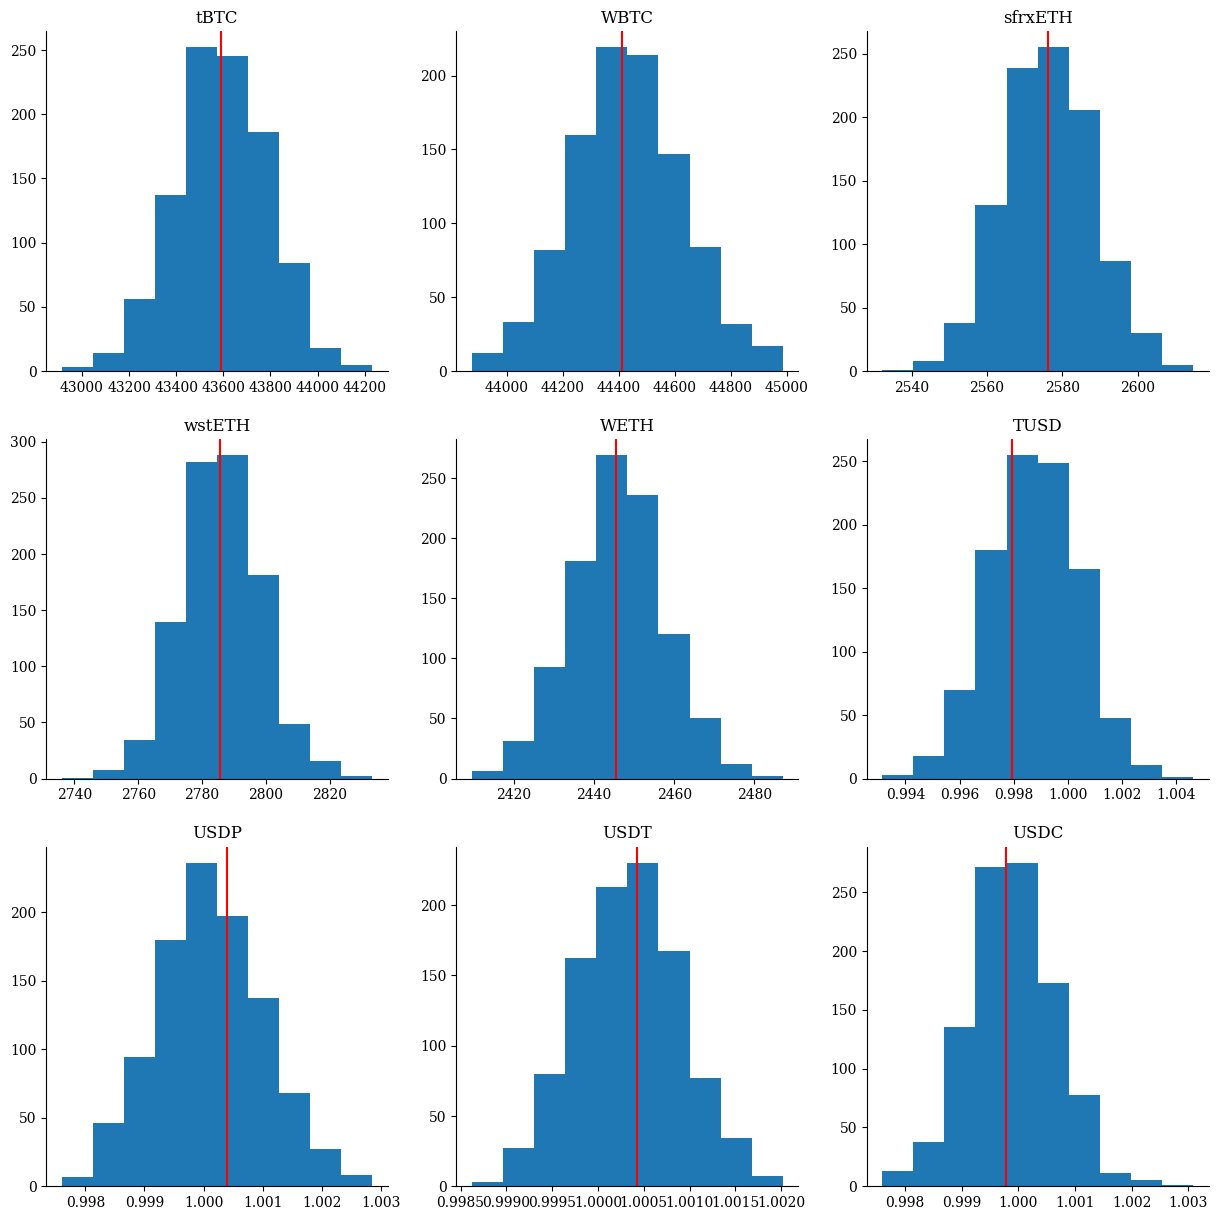

In [10]:
# Show price updates are reasonable
results = defaultdict(list)
for _ in range(1000):
    random_price_update()
    for k, v in scenario.curr_price.prices_usd.items():
        results[k].append(v)
keys = list(results.keys())
n = len(keys)
n, m = int(n**0.5), n // int(n**0.5) + (n % int(n**0.5) > 0)
f, axs = plt.subplots(n, m, figsize=(15, 15))
for i in range(n):
    for j in range(m):
        key = keys.pop()
        ax = axs[i, j]
        ax.hist(results[key])
        ax.set_title(ADDRESS_TO_SYMBOL[key])
        ax.axvline(scenario.pricepaths[-1].prices_usd[key], color="red")

In [81]:
# Make sure the optimization is working regardless of method or price change
times = []
results = []


def analyze(n_sample_prices=1, n_sample_timeit=10):
    for price_num in range(n_sample_prices):
        print(f"Price num: {price_num}")
        random_price_update()
        sample = scenario.curr_price
        for cycle_num, cycle in enumerate(scenario.cycles):
            tmp = []
            # for method in ["bounded", "brent"]:
            for method in ["bounded"]:
                for frac in [1, 1e-2, 1e-4, 1e-6, 1e-8]:
                    times_ = {
                        "price_num": price_num,
                        "cycle_num": cycle_num,
                        "method": method,
                        "frac": frac,
                    }
                    results_ = {
                        "price_num": price_num,
                        "cycle_num": cycle_num,
                        "method": method,
                        "frac": frac,
                    }
                    res = opt(cycle, method, sample, set_tol=True, frac=frac)
                    results_["profit"] = res[1]
                    tmp.append(res[1])
                    times_["time"] = (
                        timeit.timeit(
                            lambda: opt(cycle, method, sample, set_tol=True, frac=frac),
                            number=n_sample_timeit,
                            # globals=globals(),
                        )
                        / n_sample_timeit
                    )
                    times.append(times_)
                    results.append(results_)
                    if frac != 1 and res[2] == 1.0:
                        break  # frac already too low
            # make sure result is correct
            trade = cycle.trades[0]
            decimals = trade.pool.coin_decimals[trade.i]
            correct = opt(cycle, "bounded", sample, set_tol=False, frac=1)[1]
            tmp = [abs(x - correct) / 10**decimals for x in tmp]
            assert max(tmp) < 1e-6


analyze(n_sample_prices=10)
times_df = pd.DataFrame(times)
times_df = (
    times_df.set_index(["method", "frac", "price_num", "cycle_num"])
    .sort_index()
    .unstack(level=["method", "frac"])
    .bfill(axis=1)
)
times_df *= 1e3  # convert to ms
times_df = times_df.agg(["mean", "std"], axis=0)
times_df

Price num: 0
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound was too low with frac=%f, defaulting to frac=1. 0.01
Upper bound 

time                                                    
method      bounded                                                    
frac   1.000000e-08 1.000000e-06 1.000000e-04 1.000000e-02 1.000000e+00
mean       7.634545     7.634563     4.137361     5.360992     5.830925
std        4.703819     4.703790     2.838696     3.129327     4.153560

In [86]:
results_df = pd.DataFrame(results)
results_df = (
    results_df.set_index(["method", "frac", "price_num", "cycle_num"])
    .sort_index()
    .unstack(level=["method", "frac"])
    .bfill(axis=1)
)
results_df.head()

profit                                         \
method                   bounded                                          
frac                1.000000e-08 1.000000e-06 1.000000e-04 1.000000e-02   
price_num cycle_num                                                       
0         0           -52.872302   -52.872302   -52.872302   -52.872302   
          1          -123.676996  -123.676996  -123.676996  -123.676996   
          2          -416.602319  -416.602319  -416.602319  -416.602319   
          3             0.033097     0.033097     0.059363     0.047696   
          4             0.001114     0.001114     0.000739     0.001057   

                                  
method                            
frac                1.000000e+00  
price_num cycle_num               
0         0           -52.872302  
          1          -123.676996  
          2          -416.602319  
          3             0.033097  
          4             0.001114

In [87]:
def test(n_samples=1):
    broken = []
    for _ in range(n_samples):
        random_price_update()
        sample = scenario.curr_price
        for _, cycle in enumerate(scenario.cycles):
            # make sure result is correct
            trade = cycle.trades[0]
            decimals = trade.pool.coin_decimals[trade.i]
            address = trade.pool.coin_addresses[trade.i].lower()
            one_dollah = 1 / sample.prices_usd[address]
            correct = opt(cycle, "bounded", sample, set_tol=False, frac=1)[1]
            # for method in ["bounded", "brent"]:
            for method in ["bounded"]:
                for frac in [1, 1e-2, 1e-4, 1e-6, 1e-8]:
                    res = opt(cycle, method, sample, set_tol=True, frac=frac)[1]
                    diff = abs(res - correct)
                    if diff > one_dollah:
                        broken.append(
                            {
                                "cycle": cycle,
                                "method": method,
                                "frac": frac,
                                "diff": diff,
                                "correct": correct,
                                "res": res,
                                "one_dollah": one_dollah,
                            }
                        )
    return broken


broken = test(n_samples=100)
broken

Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-08
Upper bound was too low with frac=%f, defaulting to frac=1. 1e-06
Upper boun

[]

In [97]:
profile = pstats.Stats("../logs/sim.prof")
profile.sort_stats(pstats.SortKey.CUMULATIVE)
profile.print_stats()

Fri Dec  8 01:01:24 2023    ../logs/sim.prof

         84803270 function calls (82473699 primitive calls) in 138.041 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002  138.128  138.128 /root/crvUSDrisk/src/sim/__init__.py:16(sim)
      168    0.003    0.000  110.658    0.659 /root/crvUSDrisk/src/sim/scenario.py:167(perform_actions)
      168    0.006    0.000   87.389    0.520 /root/crvUSDrisk/src/agents/arbitrageur.py:35(arbitrage)
      660    0.141    0.000   86.703    0.131 /root/crvUSDrisk/src/agents/arbitrageur.py:93(find_best_arbitrage)
    13200    0.069    0.000   86.520    0.007 /root/crvUSDrisk/src/trades/cycle.py:78(optimize)
13094/10248    0.216    0.000   84.987    0.008 /root/crvUSDrisk/src/trades/cycle.py:186(_optimize_mem)
    13090    0.248    0.000   79.488    0.006 /root/crvUSDrisk/venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:754(minimize_scalar)
    13090    

In [142]:
spool = scenario.stableswap_pools[0]
i = 0
j = 1
high = spool.get_max_trade_size(i, j)
amt_out = int(np.random.uniform(0, high))
print(amt_out)
amt_in_search = scenario.liquidator.search(spool, i, j, amt_out)
amt_in_dy = spool.get_dx(i, j, amt_out)
abs(amt_in_search - amt_in_dy) / amt_in_dy

1296964481851627732467712


3.429719667887822e-11

In [122]:
%timeit scenario.liquidator.search(spool, i, j, amt_out)

328 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [123]:
%timeit spool.get_dx(i, j, amt_out)

12 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
